In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax

# Phylogenetic root and inner nodes estimated via _phylogenetic independent contrasts_ (PIC) 

We show how to use Hyperiax for estimating the root and inner nodes of a phylogenetic tree, using independent contrasts<sup>[1](#footnote1)</sup>. The independent contrasts algorithm consists of local computations on the tree and is therefore well-suited for the Hyperiax framework. It assumes given a tree topology (number of nodes, edges between them and edge-lengths) and node values only for the leaf-nodes. Inner nodes are to be estimated.

#### Inner nodes and root

Inner nodes are estimated as a weighted mean of their children,

$$
x_p = \frac{\frac{1}{e_{x_1}} x_1 + \frac{1}{e_{x_2}}x_2}{\frac{1}{e_{x_1}}+\frac{1}{e_{x_2}}},
$$

where $x_p$ is the value of the parent node of children $x_1$ and $x_2$ and $e_x$ is the length of the edge between node $x$ and its parent.

To account for uncertainty in estimating inner nodes, the PIC estimator modifies the edge lengths according to: 

$$
e_{x} = e_x +\frac{ e_{x_1}*e_{x_2}}{e_{x_1}+e_{x_2}}.
$$

Below, we

1. define a tree topology and simulate node values based on the Brownian motion model (nb: this step is identical to the mean_estimation example notebook).
2. define the 'transform' and 'up' functions needed to compute the PIC estimator.
3. plot the estimated tree.


<a name="footnote1">1</a>: See e.g. Luke Harmon's [introduction](https://bio.libretexts.org/Bookshelves/Evolutionary_Developmental_Biology/Phylogenetic_Comparative_Methods_(Harmon)/04%3A_Fitting_Brownian_Motion/4.02%3A_Estimating_Rates_using_Independent_Contrasts).


# 1. Create tree topology and simulate node values

As mentioned, this section is essentially identical to the mean_estimation notebook - refer to that notebook for explanations of the steps.

In [4]:
topology = symmetric_topology(height=2, degree=2)
plot_tree_text(topology)

   *
 ┌─┴─┐
 *   * 
┌┴┐ ┌┴┐
* * * *


In [5]:
tree = HypTree(topology)

tree.add_property('noise', shape=(2,))  # to be used for brownian motion simulation of the node values
tree.add_property('edge_length', shape=(1,))
tree.add_property('value', shape=(2,))

In [17]:
# set edge lengths
tree.data['edge_length'] = jax.numpy.array([[1.,2.,3.,4.,5.,6.,7.]]).T # example edge lengths

# set noise, for simulating the node values
key = PRNGKey(0)
key, subkey = split(key)
tree.data['noise'] = jax.random.normal(subkey, shape=tree.data['noise'].shape)

In [7]:
@jax.jit
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length)*noise+parent_value}

tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])

downmodel = DownLambda(down_fn=down)
exe = OrderedExecutor(downmodel)

exe.down(tree)

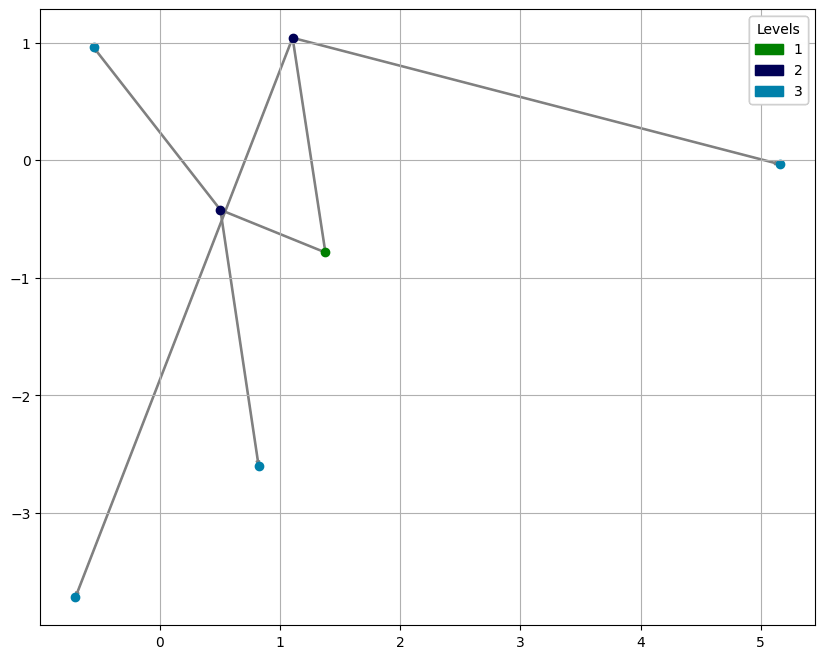

In [8]:
plot_tree_2d_scatter(tree, 'value')

# 2. Estimation of inner nodes via independent contrasts

Initialize an 'estimated value' property for each node. For leaf-nodes, the value is set to the true, known value.

In [9]:
tree.add_property('estimated_value', shape=(2,))
leaf_data = tree.data['value'][tree.is_leaf]
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.is_leaf].set(leaf_data)

Define the appropriate 'up' and 'transform' functions. We first construct the adjusted edge-lengths of the tree. This step depends only on the given edge lengths, so can be done as a preprocessing step.

In [21]:
tree.add_property('edge_length_PIC', shape=(1,))  # we add a new property to store the PIC-adjusted edge lengths
tree.data['edge_length_PIC'] = tree.data['edge_length']

def transform_PIC_edge_adjustments(edge_length_PIC, child_edge_length_PIC_sum, child_edge_length_PIC_prod, **kwargs):

    corrected_edge_length_PIC = edge_length_PIC + child_edge_length_PIC_prod/child_edge_length_PIC_sum

    return {'edge_length_PIC': corrected_edge_length_PIC}

def up_PIC_edge_adjustments(edge_length_PIC, **kwargs):
    return {'edge_length_PIC_sum': edge_length_PIC,
            'edge_length_PIC_prod': edge_length_PIC}

upmodel_PIC_edge_edjustments = UpLambdaReducer(up_PIC_edge_adjustments, transform_PIC_edge_adjustments, 
                   reductions={
                       'edge_length_PIC_sum': 'sum',
                       'edge_length_PIC_prod': 'prod'
                    }
        )

upward_exe_PIC_edge_adjustments = OrderedExecutor(upmodel_PIC_edge_edjustments)

upward_exe_PIC_edge_adjustments.up(tree)

print('Original edge lengths: \n ', tree.data['edge_length'],'\n\nAdjusted edge lengths: \n ', tree.data['edge_length_PIC'])

Original edge lengths: 
  [[1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]] 

Adjusted edge lengths: 
  [[3.5167623]
 [4.2222223]
 [6.230769 ]
 [4.       ]
 [5.       ]
 [6.       ]
 [7.       ]]


In [22]:
# PIC node estimation

def transform_node_est(child_weighted_value, child_inverse_edge_length, **kwargs):
    return {'estimated_value': child_weighted_value/child_inverse_edge_length}

def up_node_est(estimated_value, edge_length_PIC, **kwargs):
    return {'weighted_value': estimated_value/edge_length_PIC, 'inverse_edge_length':1/edge_length_PIC}

upmodel_node_est = UpLambdaReducer(up_node_est, transform_node_est, 
                   reductions={
                       'weighted_value': 'sum', 
                       'inverse_edge_length': 'sum'
                    }
        )
upward_exe_node_est = OrderedExecutor(upmodel_node_est)
upward_exe_node_est.up(tree)

# 3. Plot estimated tree

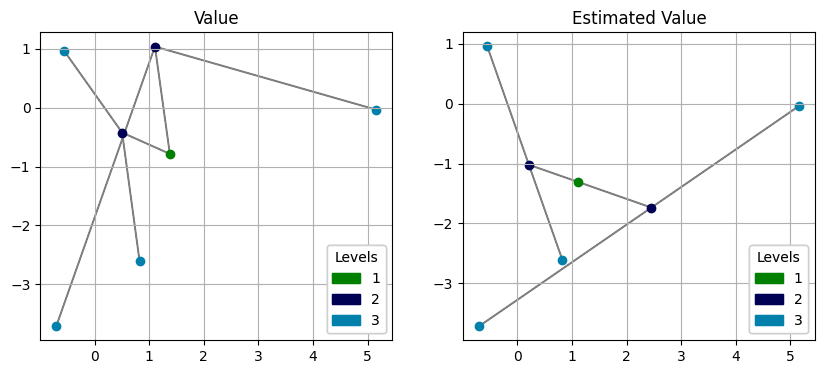

In [23]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'estimated_value', ax=ax[1])
ax[1].set_title('Estimated Value');